In [1]:
from importlib import reload
import tensorflow as tf

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [50]:
from utils_v2 import *

import GreenTeaDQNAgent
reload(GreenTeaDQNAgent)
from GreenTeaDQNAgent import GreenTeaDQNAgent

In [8]:
import datetime

In [51]:
agent = GreenTeaDQNAgent(cash_supply=5000, epsilon_decay=0.9)

In [5]:
# features
agent.external_states

['USDT_BTC_high',
 'USDT_BTC_low',
 'USDT_BTC_close',
 'USDT_BTC_open',
 'USDT_BTC_weighted_mean',
 'USDT_BTC_volatility',
 'USDT_BTC_pctChange',
 'USDT_BTC_open_label',
 'USDT_BTC_pctChange_label',
 'USDT_BTC_volatility_label']

In [78]:
import matplotlib.pyplot as plt

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def plot_test(start_time, end_time=None):

    if end_time is None: # default: one day
        end_time = agent.env.end_index
        
    df = agent.env.df
    df = df.loc[df.index >= start_time]
    df = df.loc[df.index <= end_time]
    prices = df['USDT_BTC_open']
#     print(prices.shape)
#     print(smooth(prices))
    
    actions = agent.test_actions
    actions = actions[actions.index >= start_time]
    actions = actions[actions.index < end_time]

    fig, ax1 = plt.subplots(figsize = (15, 8))

    ax1.plot(prices.index, prices, 'b-')
    ax1.set_ylabel('Price', color='b', fontsize=15)
    ax1.tick_params('y', colors='b', labelsize=15)

    hold = actions[actions == 1]
    buy = actions[actions == 2]
    sell = actions[actions == 0]


    
    sm =  smooth(prices,24)[12:len(prices.index)+12]
    import numpy as np
    from scipy.signal import argrelextrema

    local_minima = argrelextrema(sm,np.less) 
    local_maxima = argrelextrema(sm,np.greater)
    turning = np.concatenate((local_minima[0],local_maxima[0]),axis=0)
    turning = np.append(turning,0)
    turning = np.append(turning,len(prices.index) - 1)
    turning.sort()
    sell_first = True
    if (prices[0] < prices[1]):
        sell_first = False
    l_turning = list(turning)
    edge = []
    edge.append(0)
    for i in range(len(l_turning) - 1):
        edge.append((l_turning[i] + l_turning[i + 1])//2)
    edge.append(len(prices.index) - 1)
    
    good_action = []
    cur_action = 0 # sell
    last_edge = 0
    if (not sell_first):
        cur_action = 2 # buy
    for i in range(1,len(edge)):
        target_edge = edge[i]
        for j in np.arange(last_edge,target_edge,1):
            good_action.append(cur_action)
        cur_action = 2 - cur_action
        last_edge = target_edge
        
    good_action_df = pd.DataFrame()
    good_action_df["good_action"] = good_action
    good_action_df.index = actions.index


    
    good_buy = actions[(actions == 2) & (actions == good_action)]
    bad_buy = actions[(actions== 2) & (actions != good_action)]
    good_sell = actions[(actions == 0) & (actions == good_action)]
    bad_sell = actions[(actions== 0) & (actions != good_action)] 
        
    ax2 = ax1.twinx()
    ax2.scatter(hold.index, hold, c='blue', label='HOLD')
    ax2.scatter(good_buy.index, good_buy, c='green', marker = 'o',label='GOOD_BUY')
    ax2.scatter(bad_buy.index, bad_buy, c='green',marker = 'x', label='BAD_BUY')
    ax2.scatter(good_sell.index, good_sell, c='red', marker = 'o', label='GOOD_SELL')
    ax2.scatter(bad_sell.index, bad_sell, c='red', marker = 'x', label='BAD_SELL')
    ax2.set_yticks([])
    ax2.legend(loc=1, fontsize=15)
        
    
    ax3 = ax1.twinx()
    ax3.plot(prices.index,sm, 'r-')
    ax3.tick_params('y_smooth', colors='r', labelsize=15)
    ax3.set_yticks([])
    
    ax4 = ax1.twinx()
    ax4.set_ylim(0,6000)
    ax4.plot(prices.index, agent.test_portfolio_values_cash, 'y', label='Cash Value')
    ax4.plot(prices.index, agent.test_portfolio_values_coin, 'orange', label='Coin Value in USD')
    ax4.legend(loc=4, fontsize=15)

    plt.xlim(actions.index[0], actions.index[-1])       

    plt.show()

# Train (2017-12-01 ~ 2018-01-01)

In [ ]:
train_start = datetime.datetime(2017,12,1,0)
train_end = datetime.datetime(2018,1,1,0)

sess = tf.Session()
agent.train(experiment_name='GreenTea', session=sess, start_time = train_start, \
            end_time = train_end, num_episodes=1000000, verbose=False) # SHOULD USE MORE EPOCHS!!!

INFO:tensorflow:Restoring parameters from GreenTea/model.ckpt
Start from saved checkpoint...
Training from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

episode: 1/1000000, returns: 1.5e+01, epsilon: 0.001
7441
episode: 2/1000000, returns: 2e+01, epsilon: 0.001
8186
episode: 3/1000000, returns: 1.3e+01, epsilon: 0.001
8931
episode: 4/1000000, returns: 1.3e+01, epsilon: 0.001
9676
episode: 5/1000000, returns: 1.7e+01, epsilon: 0.001
10421
episode: 6/1000000, returns: 1.2e+01, epsilon: 0.001
11166
episode: 7/1000000, returns: 1.5e+01, epsilon: 0.001
11911
episode: 8/1000000, returns: 1.3e+01, epsilon: 0.001
12656
episode: 9/1000000, returns: 1.5e+01, epsilon: 0.001
13401
episode: 10/1000000, returns: 1.3e+01, epsilon: 0.001
14146
episode: 11/1000000, returns: 1.7e+01, epsilon: 0.001
14891
episode: 12/1000000, returns: 1.9e+01, epsilon: 0.001
15636
episode: 13/1000000, returns: 6.4, epsilon: 0.001
16381
episode: 14/1000000, returns: 1.7e+01, epsilon: 0.001
17126
episode: 15/1

# Sanity check

In [201]:
agent.env.set_current_time(datetime.datetime(2017,12,1,0))

In [46]:
agent.env.step()
state = agent.env.getStatesSequence() + agent.portfolio.getStates()
state -= agent.state_mean
print(state[:10])

agent.model.predict(sess, state)

[ 6.30715543e+03  6.21901057e+03  6.29140289e+03  6.41853110e+03
  6.27622239e+03  3.67999559e-03 -2.46602433e-03  4.49982906e+00
 -5.18351475e-01  3.41316126e+00]


array([[ -7.7465386, -14.56895  , -13.169879 ]], dtype=float32)

In [48]:
sm = agent.state_mean

In [35]:
experiment_name = 'GreenTea'
agent.saver.save(sess, "./"+experiment_name+"/model.ckpt")

'./GreenTea/model.ckpt'

# Test on (2017-09-01 ~ 2018,1,1,0) Cheating...

In [52]:
agent.saver.restore(sess, "./"+experiment_name+"/model.ckpt")
agent.state_mean = sm

INFO:tensorflow:Restoring parameters from ./GreenTea/model.ckpt


In [55]:
test_start = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

Current time: 2017-12-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:9740.005
After buying: coin bought:0.051, transaction fees:1.250, coin now:0.051, cash now:4498.750
Action end:  Action.BUY , Total value now: 4998.750.  , Return since entry: -0.025 %

Current time: 2017-12-02 00:00:00
Action start: Action.HOLD , Total value before action: 5208.800337012783
Action end:  Action.HOLD , Total value now: 5208.800.  , Return since entry: 4.176 %

Current time: 2017-12-03 00:00:00
Action start: Action.HOLD , Total value before action: 5191.072599130404
Action end:  Action.HOLD , Total value now: 5191.073.  , Return since entry: 3.821 %

Current time: 2017-12-04 00:00:00
Action start: Action.HOLD , Total value before action: 5288.242414794846
Action end:  Action.HOLD , Total value now: 5288.242.  , Return since entry: 5.765 %

Current time: 20

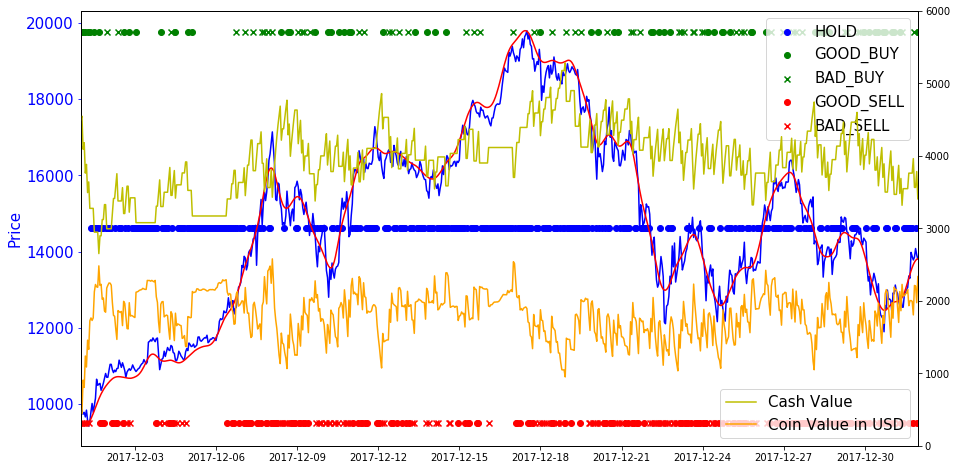

In [72]:
plot_test(test_start, test_end)

# Test on unseen time period (2018-01-01 ~ )

In [80]:
test_start = datetime.datetime(2018,1,1,0)
test_end = datetime.datetime(2018,4,11,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2018-01-01 00:00:00  to 2018-04-11 00:00:00 :  ~ 100 days

Current time: 2018-01-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:13597.959
After buying: coin bought:0.037, transaction fees:1.250, coin now:0.037, cash now:4498.750
Action end:  Action.BUY , Total value now: 4998.750.  , Return since entry: -0.025 %

Current time: 2018-01-02 00:00:00
Action start: Action.HOLD , Total value before action: 5047.160499622119
Action end:  Action.HOLD , Total value now: 5047.160.  , Return since entry: 0.943 %

Current time: 2018-01-03 00:00:00
Action start: Action.HOLD , Total value before action: 5182.812273194559
Action end:  Action.HOLD , Total value now: 5182.812.  , Return since entry: 3.656 %

Current time: 2018-01-04 00:00:00
Action start: Action.HOLD , Total value before action: 5209.47662823859
Action end:  Action.HOLD , Total value now: 5209.477.  , Return since entry: 4.190 %

Current time: 2

Current time: 2018-02-03 00:00:00
Action start: Action.BUY , Total value before action: 4301.34655377499
Before buying: coin:0.191, cash:2627.489, buy price:8776.401
After buying: coin bought:0.030, transaction fees:0.657, coin now:0.221, cash now:2364.083
Action end:  Action.BUY , Total value now: 4300.690.  , Return since entry: -13.986 %

Current time: 2018-02-04 00:00:00
Action start: Action.SELL , Total value before action: 4349.089071895341
Before selling: coin:0.204, cash:2503.524, sell price:9064.065
After selling: coin sold:0.020, transaction fees:0.461, coin now:0.183, cash now:2687.619
Action end:  Action.SELL , Total value now: 4348.628.  , Return since entry: -13.027 %

Current time: 2018-02-05 00:00:00
Action start: Action.HOLD , Total value before action: 4136.3632230512885
Action end:  Action.HOLD , Total value now: 4136.363.  , Return since entry: -17.273 %

Current time: 2018-02-06 00:00:00
Action start: Action.BUY , Total value before action: 3843.47571322086
Before 

Current time: 2018-03-14 00:00:00
Action start: Action.SELL , Total value before action: 4396.285234466483
Before selling: coin:0.167, cash:2847.891, sell price:9293.995
After selling: coin sold:0.017, transaction fees:0.387, coin now:0.150, cash now:3002.343
Action end:  Action.SELL , Total value now: 4395.898.  , Return since entry: -12.082 %

Current time: 2018-03-15 00:00:00
Action start: Action.HOLD , Total value before action: 4132.098121292017
Action end:  Action.HOLD , Total value now: 4132.098.  , Return since entry: -17.358 %

Current time: 2018-03-16 00:00:00
Action start: Action.HOLD , Total value before action: 4108.460886747495
Action end:  Action.HOLD , Total value now: 4108.461.  , Return since entry: -17.831 %

Current time: 2018-03-17 00:00:00
Action start: Action.HOLD , Total value before action: 4186.968062474648
Action end:  Action.HOLD , Total value now: 4186.968.  , Return since entry: -16.261 %

Current time: 2018-03-18 00:00:00
Action start: Action.HOLD , Total

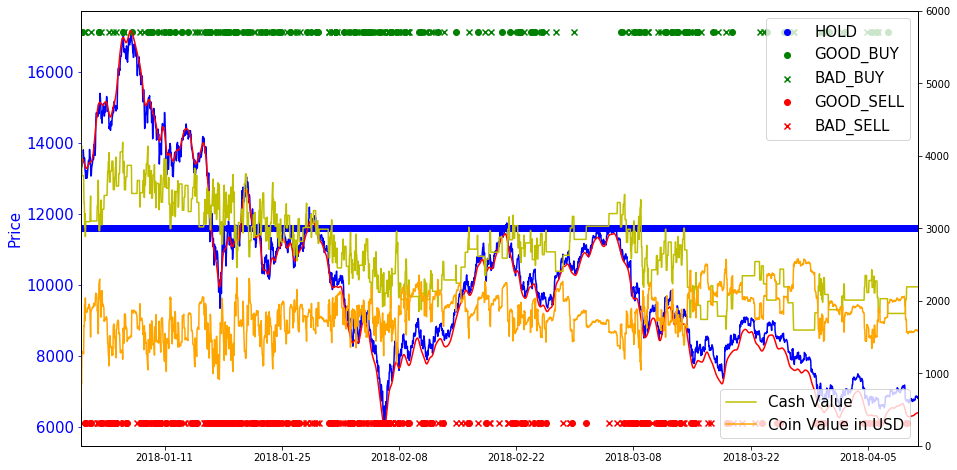

In [81]:
plot_test(test_start, test_end)

# Save Model (Optional)

In [15]:
# to be implemented.... sorry....

# Always buy agent

In [204]:
from simple_agents import *

In [205]:
always_buy_agent = AlwaysBuyAgent(Action)

In [206]:
env = Environment()
now = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
env.set_current_time(now)
portfolio = Portfolio(cash_supply=1e8)
while True:
    action = always_buy_agent.get_action()
    if (env.current_index - env.start_index) / env.time_delta % 24 == 0:
        verbose = True
        print('Current time:', env.current_index)
    else:
        verbose = False
    current_price = env.getCurrentPrice()
    action = portfolio.apply_action(current_price, action, verbose=verbose)
    is_done, state = env.step()
    if env.current_index == test_end:
        break
print("Initial cash supply:", portfolio.starting_cash)
print("Final holdings:", portfolio.getCurrentHoldings(env.getCurrentPrice()))

Current time: 2017-12-01 13:00:00
Action start: Action.BUY , Total value before action: 101768167.32603675
Before buying: coin:7583.457, cash:25327021.511, buy price:10218.013
After buying: coin bought:247.866, transaction fees:6331.755, coin now:7831.323, cash now:22787987.604
Action end:  Action.BUY , Total value now: 101727623.464.  , Return since entry: 1.728 %

Current time: 2017-12-02 13:00:00
Action start: Action.BUY , Total value before action: 109454130.3945612
Before buying: coin:9763.814, cash:2006821.046, buy price:11155.333
After buying: coin bought:17.990, transaction fees:501.705, coin now:9781.804, cash now:1805637.237
Action end:  Action.BUY , Total value now: 109450917.846.  , Return since entry: 9.451 %

Current time: 2017-12-03 13:00:00
Action start: Action.BUY , Total value before action: 114972193.9853586
Before buying: coin:9931.208, cash:159013.199, buy price:11719.152
After buying: coin bought:1.357, transaction fees:39.753, coin now:9932.564, cash now:143072.1

Current time: 2017-12-30 13:00:00
Action start: Action.BUY , Total value before action: 123570645.59934495
Before buying: coin:9944.905, cash:0.000, buy price:12595.667
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 123570645.599.  , Return since entry: 23.571 %

Current time: 2017-12-31 13:00:00
Action start: Action.BUY , Total value before action: 128366983.95875396
Before buying: coin:9944.905, cash:0.000, buy price:13084.562
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 128366983.959.  , Return since entry: 28.367 %

Initial cash supply: 100000000.0
Final holdings: 9944.90 coins, 0.00 cash, 136306457.98 current value, 36.31 percent returns
